In [47]:
import os
import datetime

In [48]:
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
nowtime

'2022-04-04 14-16-28'

## 1. 准备数据

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader,TensorDataset

In [50]:
train_file = pd.read_csv('train.csv')
test_file = pd.read_csv('test.csv')

In [51]:
train_file # Survives = 1 存活
           # Pclass：乘客的票类
           # SibSp： 兄弟姐妹/配偶的个数
           # Parch： 乘客父母/孩子的个数
           # Fare： 票价
           # Cabin： 所在的船舱
           # Embarked： 乘客登船港口

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
707,859,1,3,"Baclini, Mrs. Solomon (Latifa Qurban)",female,24.0,0,3,2666,19.2583,NaN,C
708,65,0,1,"Stewart, Mr. Albert A",male,NaN,0,0,PC 17605,27.7208,NaN,C
709,130,0,3,"Ekstrom, Mr. Johan",male,45.0,0,0,347061,6.9750,NaN,S
710,21,0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S


In [52]:
train_file['Survived'].value_counts()

0    433
1    279
Name: Survived, dtype: int64

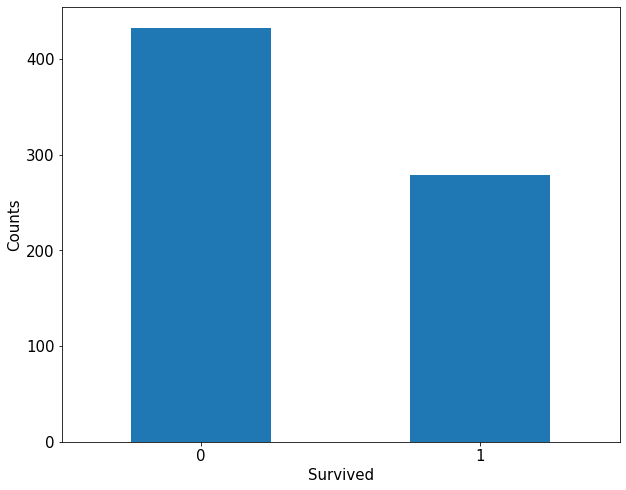

In [53]:
survived = train_file['Survived'].value_counts().plot(kind = 'bar', figsize = (10, 8), fontsize = 15, rot = 0)
survived.set_ylabel('Counts', fontsize = 15)
survived.set_xlabel('Survived', fontsize = 15)
plt.show()

In [54]:
train_file['Age'].value_counts()

24.00    27
30.00    21
22.00    21
28.00    21
25.00    21
         ..
63.00     1
0.42      1
80.00     1
14.50     1
71.00     1
Name: Age, Length: 82, dtype: int64

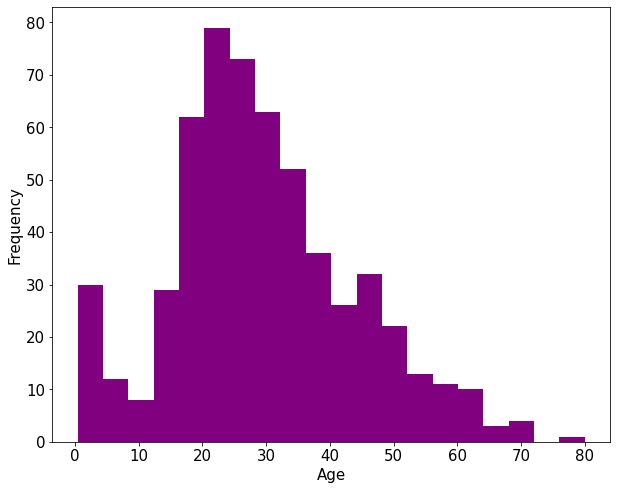

In [55]:
age = train_file['Age'].plot(kind = 'hist', bins = 20, color = 'purple', figsize = (10, 8), fontsize = 15)
age.set_ylabel('Frequency', fontsize = 15)
age.set_xlabel('Age', fontsize = 15)
plt.show()

In [56]:
train_file.query('Survived == 0')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
706,19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.0,1,0,345763,18.0000,NaN,S
708,65,0,1,"Stewart, Mr. Albert A",male,NaN,0,0,PC 17605,27.7208,NaN,C
709,130,0,3,"Ekstrom, Mr. Johan",male,45.0,0,0,347061,6.9750,NaN,S
710,21,0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S


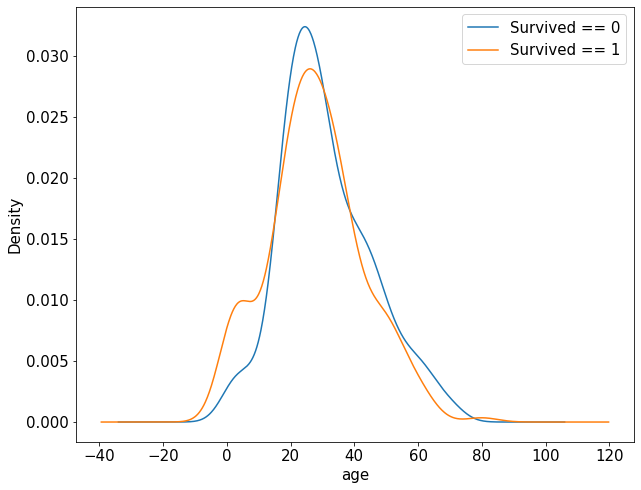

In [57]:
age_related = train_file.query('Survived == 0')['Age'].plot(kind = 'density', figsize = (10, 8), fontsize = 15)
train_file.query('Survived == 1')['Age'].plot(kind = 'density', figsize = (10, 8), fontsize = 15)
age_related.legend(['Survived == 0', 'Survived == 1'], fontsize = 15)
age_related.set_ylabel('Density', fontsize = 15)
age_related.set_xlabel('age', fontsize = 15)
plt.show()

In [89]:
# 接下来对数据进行处理
def preprocessing(dfdate):
    dfresult = pd.DataFrame()
    
    # Pclass : 乘客的票类
    dfPclass = pd.get_dummies(dfdate['Pclass']) # 对类别进行one-hot编码
    dfPclass.columns = ['Pclass_' + str(x) for x in dfPclass.columns]
    dfresult = pd.concat([dfresult, dfPclass], axis = 1) # axis= 1，横向合并
    
    
    # Sex
    dfSex = pd.get_dummies(dfdate['Sex'])
    dfresult = pd.concat([dfresult, dfSex], axis = 1)
    
    # Age 有的年龄段为Nan，需要补零
    dfresult['Age'] = dfdate['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdate['Age']).astype('int32') # isna是用来空值或者缺失值
    #dfresult = pd.concat([dfresult, dfAge], axis = 1)
    
    
    # SibSp, Parch,Fare
    dfresult['SibSp'] = dfdate['SibSp']
    dfresult['Parch'] = dfdate['Parch']
    dfresult['Fare'] = dfdate['Fare']
    
    # Cabin：所在的船舱
    dfresult['Cabin_null'] = pd.isna(dfdate['Cabin']).astype('int32')
    
    # Embarked： 乘客登船港口
    dfEmbarked = pd.get_dummies(dfdate['Embarked'], dummy_na = True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult, dfEmbarked], axis = 1)
    return dfresult
preprocessing(train_file)

,Pclass_1,Pclass_2,Pclass_3,female,male,Age,Age_null,SibSp,Parch,Fare,Cabin_null,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,0,0,0,1,55.0,0,0,0,30.5000,0,0,0,1,0
1,1,0,0,1,0,49.0,0,1,0,76.7292,0,1,0,0,0
2,0,1,0,1,0,36.0,0,0,0,13.0000,1,0,0,1,0
3,0,1,0,0,1,19.0,0,0,0,13.0000,1,0,0,1,0
4,0,0,1,0,1,14.0,0,4,1,39.6875,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,0,0,1,1,0,24.0,0,0,3,19.2583,1,1,0,0,0
708,1,0,0,0,1,0.0,1,0,0,27.7208,1,1,0,0,0
709,0,0,1,0,1,45.0,0,0,0,6.9750,1,0,0,1,0
710,0,1,0,0,1,35.0,0,0,0,26.0000,1,0,0,1,0


In [90]:
x_train = preprocessing(train_file).values
x_train.shape

(712, 15)

In [100]:
x_train,x_train.shape

(array([[1., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 1., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 1., 0.]]),
 (712, 15))

In [92]:
y_train = train_file[['Survived']].values
y_train.shape

(712, 1)

In [93]:
test_file

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.5500,NaN,S
1,405,0,3,"Oreskovic, Miss. Marija",female,20.00,0,0,315096,8.6625,NaN,S
2,635,0,3,"Skoog, Miss. Mabel",female,9.00,3,2,347088,27.9000,NaN,S
3,701,1,1,"Astor, Mrs. John Jacob (Madeleine Talmadge Force)",female,18.00,1,0,PC 17757,227.5250,C62 C64,C
4,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...,...
174,650,1,3,"Stanley, Miss. Amy Zillah Elsie",female,23.00,0,0,CA. 2314,7.5500,NaN,S
175,649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S
176,577,1,2,"Garside, Miss. Ethel",female,34.00,0,0,243880,13.0000,NaN,S
177,78,0,3,"Moutal, Mr. Rahamin Haim",male,NaN,0,0,374746,8.0500,NaN,S


In [96]:
x_test = preprocessing(test_file).values
y_test = test_file[['Survived']].values

In [101]:
x_test,x_test.shape

(array([[0., 0., 1., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 1., 0.],
        ...,
        [0., 1., 0., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 1., 0.]]),
 (179, 15))

In [98]:
y_test.shape

(179, 1)

In [99]:
# 进一步使用DataLoader和TensorDataset封装成可以迭代的数据管道。
dl_train = DataLoader(TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).float()), shuffle = True, batch_size = 8)
dl_teat = DataLoader(TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).float()), shuffle = False, batch_size = 8)

In [102]:
dl_train

In [104]:
for features, labels in dl_train:
    print(features, labels)
    break

tensor([[ 1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  1.0000,
          0.0000, 89.1042,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000, 16.0000,  0.0000,  0.0000,
          0.0000,  7.7500,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  7.2250,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000, 45.0000,  0.0000,  0.0000,
          1.0000, 14.4542,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  1.0000,  0.0000, 35.0000,  0.0000,  1.0000,
          0.0000, 83.4750,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000, 24.0000,  0.0000,  0.0000,
          0.0000,  7.8958,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000, 20.0000,  0.0000,  1.0

## 2. 定义模型

### 使用Pytorch有三种模型的定义
####    1.使用nn.Sequential按层顺序构建模型
####    2.继承nn.Moudle基类构建自定义模型
####    3.继承nn.Moudle基类构建模型并辅助应用模型容器进行封装

In [105]:
def creat_net():
    net = nn.Sequential()
    net.add_module('linear1', nn.Linear(15, 20))
    net.add_module('relu1', nn.ReLU())
    net.add_module('linear2', nn.Linear(20, 15))
    net.add_module('relu2', nn.ReLU())
    net.add_module('linear3', nn.Linear(15, 1))
    net.add_module('Sigmoid', nn.Sigmoid())
    return net
net = creat_net()
print(net)

Sequential(
  (linear1): Linear(in_features=15, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=15, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=15, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)


In [107]:
from torchkeras import summary

In [108]:
summary(net, input_shape = (15, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]             320
              ReLU-2                   [-1, 20]               0
            Linear-3                   [-1, 15]             315
              ReLU-4                   [-1, 15]               0
            Linear-5                    [-1, 1]              16
           Sigmoid-6                    [-1, 1]               0
Total params: 651
Trainable params: 651
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000057
Forward/backward pass size (MB): 0.000549
Params size (MB): 0.002483
Estimated Total Size (MB): 0.003090
----------------------------------------------------------------


### 3. 训练模型
#### 1. 脚本形式训练模型
#### 2. 函数形式训练模型
#### 3. 类形式训练模型

In [111]:
from sklearn.metrics import accuracy_score

In [112]:
loss_func = nn.BCELoss()
loss_func

BCELoss()

In [114]:
optimizer = torch.optim.Adam(params = net.parameters(), lr = 0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [115]:
metric_func = lambda y_pred, y_true : accuracy_score(y_true.data.numpy(), y_pred.data.numpy() > 0.5)
metric_func

<function __main__.<lambda>(y_pred, y_true)>

In [116]:
metric_name = 'accuracy'
metric_name

'accuracy'

In [117]:
epochs = 10
log_step_freq = 30

In [118]:
dfhistory = pd.DataFrame(columns = ['epochs', 'loss', metric_name, 'val_loss', 'val_' + metric_name])

In [119]:
dfhistory

,epochs,loss,accuracy,val_loss,val_accuracy


In [128]:
print('训练开始......')
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
print('=========='*8 + '%s'%nowtime)

for epoch in range(1, epochs + 1):
    
    # 1. 循环训练---------
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features, labels) in enumerate(dl_train, 1):
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 正向转播求损失
        predictions = net(features)
        loss = loss_func(predictions, labels)
        metric = metric_func(predictions,labels)
        
        # 反向传播求提梯度
        loss.backward()
        optimizer.step()
        
        # 打印日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %(step, loss_sum/step, metric_sum/step))
    
    # 2. 验证循环
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    for val_step, (features, labels) in enumerate(dl_train, 1):
        predictions = net(features)
        val_loss = loss_func(predictions, labels)
        val_metric = metric_func(predictions, labels)
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
        
    # 3，记录日志-------------------------------------------------
    info = (epoch, loss_sum/step, metric_sum/step, 
            val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
          "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
          %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
print('训练结束...')

训练开始......
================================================================================2022-04-04 15-57-08
[step = 30] loss: 0.761, accuracy: 0.667
[step = 60] loss: 0.709, accuracy: 0.665

EPOCH = 1, loss = 0.668,accuracy  = 0.671, val_loss = 0.580, val_accuracy = 0.698

================================================================================2022-04-04 15:57:09
[step = 30] loss: 0.571, accuracy: 0.717
[step = 60] loss: 0.566, accuracy: 0.729

EPOCH = 2, loss = 0.560,accuracy  = 0.722, val_loss = 0.519, val_accuracy = 0.750

================================================================================2022-04-04 15:57:09
[step = 30] loss: 0.548, accuracy: 0.725
[step = 60] loss: 0.522, accuracy: 0.756

EPOCH = 3, loss = 0.526,accuracy  = 0.763, val_loss = 0.538, val_accuracy = 0.757

================================================================================2022-04-04 15:57:09
[step = 30] loss: 0.491, accuracy: 0.800
[step = 60] loss: 0.462, accuracy: 0.810

EPOCH = 

## 4. 评估模型

In [129]:
dfhistory

,epochs,loss,accuracy,val_loss,val_accuracy
0,1.0,0.667822,0.671348,0.580111,0.698034
1,2.0,0.559830,0.721910,0.518575,0.750000
2,3.0,0.526415,0.762640,0.538288,0.757022
3,4.0,0.498616,0.783708,0.498294,0.769663
4,5.0,0.473856,0.782303,0.433891,0.796348
5,6.0,0.458960,0.800562,0.439661,0.803371
6,7.0,0.457227,0.789326,0.422066,0.811798
7,8.0,0.442020,0.803371,0.453584,0.806180
8,9.0,0.438448,0.797753,0.428437,0.806180
9,10.0,0.461228,0.803371,0.450333,0.818820


In [130]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

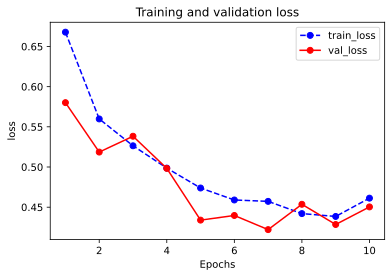

In [131]:
plot_metric(dfhistory,"loss")

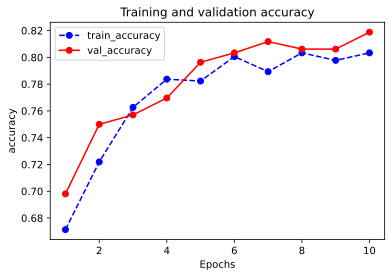

In [132]:
plot_metric(dfhistory,"accuracy")

## 5. 使用模型

In [133]:
#预测概率
y_pred_probs = net(torch.tensor(x_test[0:10]).float()).data
y_pred_probs

tensor([[0.2735],
        [0.5765],
        [0.4337],
        [0.5583],
        [0.5127],
        [0.8232],
        [0.2668],
        [0.7848],
        [0.5508],
        [0.2594]])

In [134]:
#预测类别
y_pred = torch.where(y_pred_probs > 0.5,torch.ones_like(y_pred_probs),torch.zeros_like(y_pred_probs))
y_pred

tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]])

## 6. 保存模型

### 模型保存有两种
#### 1. 只保模型参数
#### 2. 保存完整模型
#### 推荐第一种，第二种可能在切换设备和目录时出现各种问题

In [135]:
print(net.state_dict().keys())

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])


In [138]:
# 保存模型参数

torch.save(net.state_dict(), "net_parameter.pkl")
net_clone = creat_net()
net_clone.load_state_dict(torch.load("net_parameter.pkl"))
net_clone.forward(torch.tensor(x_test[0:10]).float()).data

tensor([[0.2735],
        [0.5765],
        [0.4337],
        [0.5583],
        [0.5127],
        [0.8232],
        [0.2668],
        [0.7848],
        [0.5508],
        [0.2594]])

In [139]:
## 第二种不推荐
torch.save(net, 'net_model.pkl')
net_loaded = torch.load('net_model.pkl')
net_loaded(torch.tensor(x_test[0:10]).float()).data

tensor([[0.2735],
        [0.5765],
        [0.4337],
        [0.5583],
        [0.5127],
        [0.8232],
        [0.2668],
        [0.7848],
        [0.5508],
        [0.2594]])